## Convolutional Neural Net (Trained from scratch)

#### adam optimizer

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from glob import glob
from PIL import Image
import cv2
#--------------#
# function for plotting multiple images
#--------------#
print('NORMAL') # ['CNV', 'DME', 'DRUSEN']
multipleImages = glob(train_path + 'NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

#--------------#
# function for plotting confusion matrix
#--------------#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing import image

#--------------------------------------------------------------#
# dimensions of our images.
img_width, img_height = 256, 256
categories = 4

# define directories and parameters
train_data_dir = 'data/train'
test_data_dir = 'data/test'
validation_data_dir = 'data/validation'

# number of samples used for determining the samples_per_epoch
nb_train_samples = 83484
nb_validation_samples = 968
epochs = 20
batch_size = 32
#--------------------------------------------------------------#


# fix data format issues
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./ 255, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             rotation_range=360)


#x , y = generator.next()

# data generator for test set
test_datagen = ImageDataGenerator(rescale = 1./255)

# generator for reading train data from folder
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

# generator for reading validation data from folder
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

# generator for reading test data from folder
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = None,
    shuffle = False)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 1 classes.


In [4]:
print('train labels: ', train_generator.class_indices)
print('validation labels: ', validation_generator.class_indices)

train labels:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
validation labels:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [12]:
# construct ConvNet architecture

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [16]:
# call backs
# TensorBoard
tbcallback = keras.callbacks.TensorBoard(log_dir='./Graph',
                            histogram_freq=0,
                            write_graph=True,
                            write_images=True)

# LR Annealer for overfiting
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [17]:
History = model.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples // batch_size,
        epochs = epochs,
        verbose = 0,
        validation_data = validation_generator,
        validation_steps = nb_validation_samples // batch_size,
        callbacks = [tbcallback, red_lr])

model.save_weights('fourth_try.h5')


Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [4]:
# load json and create model
json_file = open('adam_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights/fourth_try.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


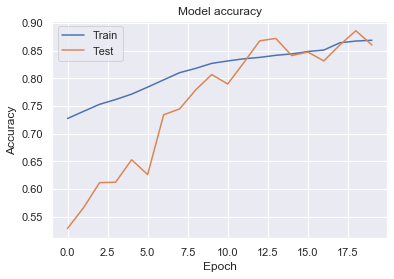

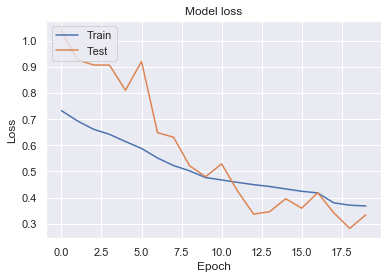

In [18]:
# Plot training & validation accuracy values
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [7]:
print('train labels: ', train_generator.class_indices)
print('validation labels: ', validation_generator.class_indices)
map_characters = validation_generator.class_indices
print(map_characters)
labels = map_characters

train labels:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
validation labels:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [13]:
# compile loaded model
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

[2] [[0. 0. 1. 0.]]
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
<class 'PIL.Image.Image'>
None
RGB
(256, 256)


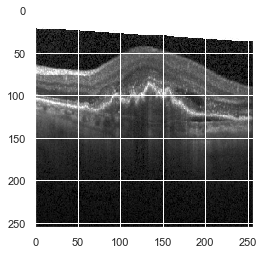

In [8]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from IPython.display import Image

test_model = loaded_model

img = load_img('data/test/test/CNV-6294785-1.jpeg', target_size=(img_width,img_height))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = test_model.predict_classes(x)
prob = test_model.predict_proba(x)
print(preds, prob)
# report details about the image
print(labels)
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
plt.imshow(img)
# img.show()  # output to local image preview

In [22]:
#--------------#
# evaulate model metrics
#--------------#

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
model = loaded_model
# evaluate generator accuracy score and print
model_score = model.evaluate_generator(
    generator=validation_generator,
    steps=nb_validation_samples // batch_size)

print("%s: %.2f%%" % (model.metrics_names[1], model_score[1]*100))

# reset validation generator
validation_generator.reset()

#--------------#
# Confution Matrix and Classification Report
#--------------#
Y_pred = loaded_model.predict_generator(train_generator, nb_validation_samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

# classification report
print('Classification Report')
target_names = ['NORMAL', 'CNV', 'DME', 'DRUSEN'] # labels
print(classification_report(
    validation_generator.classes, 
    y_pred, 
    target_names=target_names))

#--------------#
# call plt confusion matrix
#--------------#
# plt.style.use('seaborn-white')
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, classes=labels)
plt.show()

acc: 86.15%


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


#Confution Matrix and Classification Report
Y_pred = loaded_model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[234   8   0   0]
 [ 34 198   0  10]
 [ 56   1 180   5]
 [  1   1   0 240]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.72      0.97      0.83       242
         CNV       0.95      0.82      0.88       242
         DME       1.00      0.74      0.85       242
      DRUSEN       0.94      0.99      0.97       242

    accuracy                           0.88       968
   macro avg       0.90      0.88      0.88       968
weighted avg       0.90      0.88      0.88       968



In [28]:
# predict output test generator
steps_test = test_generator.n // test_generator.batch_size
test_generator.reset()
pred = model.predict_generator(
    test_generator,
    steps=steps_test,
    verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Save to CSV
filenames = test_generator.filenames
results = pd.DataFrame({'Filename':filenames,
                      'Predictions':predictions})
results.to_csv('results_inception.csv', index=False)

# load CSV and print
df_results = pd.read_csv('results_adam.csv')
print(df_results)

32/32 [==============================] - ETA:  - ETA:  - 0s 3ms/step
                      Filename Predictions
0      test\CNV-6294785-1.jpeg         CNV
1      test\CNV-6294785-2.jpeg         CNV
2      test\CNV-6652117-1.jpeg         CNV
3      test\CNV-6668596-1.jpeg         CNV
4      test\CNV-6851127-1.jpeg         CNV
5      test\CNV-6875371-1.jpeg         CNV
6      test\CNV-8184974-1.jpeg         CNV
7      test\CNV-8598714-1.jpeg         CNV
8      test\DME-9583225-1.jpeg         DME
9      test\DME-9583225-2.jpeg      NORMAL
10     test\DME-9603124-1.jpeg         DME
11     test\DME-9655949-1.jpeg         DME
12     test\DME-9721607-1.jpeg         DME
13     test\DME-9721607-2.jpeg         DME
14     test\DME-9925591-1.jpeg         DME
15     test\DME-9925591-2.jpeg         DME
16  test\DRUSEN-9800172-2.jpeg      DRUSEN
17  test\DRUSEN-9837663-1.jpeg      DRUSEN
18  test\DRUSEN-9861332-1.jpeg      DRUSEN
19  test\DRUSEN-9884539-1.jpeg      DRUSEN
20  test\DRUSEN-9884539-2.jp